In [76]:
# Import necessary libraries
import pandas as pd
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report,precision_recall_curve, auc)
import numpy as np
import seaborn as sns
from sklearn.preprocessing import label_binarize


In [77]:
df = pd.read_csv("birds.csv")
df

,class id,filepaths,labels,data set,scientific name
0,0.0,train/ABBOTTS BABBLER/001.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
1,0.0,train/ABBOTTS BABBLER/007.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
2,0.0,train/ABBOTTS BABBLER/008.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
3,0.0,train/ABBOTTS BABBLER/009.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
4,0.0,train/ABBOTTS BABBLER/002.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
...,...,...,...,...,...
89880,524.0,valid/BLACK BREASTED PUFFBIRD/3.jpg,BLACK BREASTED PUFFBIRD,valid,NOTHARCHUS PECTORALIS
89881,524.0,valid/BLACK BREASTED PUFFBIRD/4.jpg,BLACK BREASTED PUFFBIRD,valid,NOTHARCHUS PECTORALIS
89882,524.0,valid/BLACK BREASTED PUFFBIRD/1.jpg,BLACK BREASTED PUFFBIRD,valid,NOTHARCHUS PECTORALIS
89883,524.0,valid/BLACK BREASTED PUFFBIRD/2.jpg,BLACK BREASTED PUFFBIRD,valid,NOTHARCHUS PECTORALIS


In [78]:
# Getting the top 3 frequently occurring labels
top_3 = pd.value_counts(df['labels']).nlargest(3).index.tolist()

# Printing the top 3 labels
print("Top 3 frequently occurring labels:")
print(top_3)

# Define paths for training, testing, and validation data
train_path, test_path, validate_path = 'train', 'test', 'valid'

Top 3 frequently occurring labels:
['RUFOUS TREPE', 'HOUSE FINCH', 'D-ARNAUDS BARBET']


In [79]:
# Creating a Function to filter and count images for top labels
def count_images_per_label(folder_path, top_labels):
    # creating Lists to store labels and their corresponding image counts
    labels = []
    image_counts = []

    # using Loop to iterate through each top label
    for label in top_labels:
        label_path = os.path.join(folder_path, label)
        
        if os.path.isdir(label_path):
            num_images = len(os.listdir(label_path))
            labels.append(label)
            image_counts.append(num_images)
    return labels, image_counts

# Calling the function to count images for the top labels in the training set
train_labels, train_image_counts = count_images_per_label(train_path, top_3)

# Printting the top 3 labels in the training set
print("Top 3 labels in the training set:")
print(train_labels)

Top 3 labels in the training set:
['RUFOUS TREPE', 'HOUSE FINCH', 'D-ARNAUDS BARBET']


In [80]:
# Printing the number of images for each top label in the training set
print("\nNumber of images for each top label in the training set:")
for label, count in zip(train_labels, train_image_counts):
    print(f"{label}: {count} images")


Number of images for each top label in the training set:
RUFOUS TREPE: 263 images
HOUSE FINCH: 248 images
D-ARNAUDS BARBET: 233 images


In [81]:
# Defining the data augmentation parameters using ImageDataGenerator
datagen = ImageDataGenerator(
    rescale=1./255,                
    rotation_range=40,             
    width_shift_range=0.2,        
    height_shift_range=0.2,        
    shear_range=0.2,              
    zoom_range=0.2,                
    horizontal_flip=True,          
    fill_mode='nearest'            
)

# Generating batches of augmented training data from a directory
train_generator = datagen.flow_from_directory(
    train_path,                  
    target_size=(224, 224),       
    batch_size=32,                 
    class_mode='categorical',      
    classes=top_3        
)

# Generating batches of augmented validation data from a directory
validation_generator = datagen.flow_from_directory(
    validate_path,                
    target_size=(224, 224),      
    batch_size=32,                
    class_mode='categorical',      
    classes=top_3          
)


Found 744 images belonging to 3 classes.
Found 15 images belonging to 3 classes.


In [82]:
# Loading the VGG16 model with pre-trained weights
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freezing all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Importing additional layers from TensorFlow Keras
# These layers will be added on top of the VGG16 base model
x = base_model.output
x = layers.Flatten()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(3, activation='softmax')(x)

# Creating a new model using the VGG16 base and the additional layers
model = Model(inputs=base_model.input, outputs=x)

# Compiling the model with 'adam' optimizer, 'categorical_crossentropy' loss, and accuracy metric
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


Epoch 1/10
24/24 [==============================] - 38s 2s/step - loss: 0.7725 - accuracy: 0.6895 - val_loss: 0.4421 - val_accuracy: 0.7333 - lr: 1.0000e-04
Epoch 2/10
24/24 [==============================] - 38s 2s/step - loss: 0.2819 - accuracy: 0.8858 - val_loss: 0.0200 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 3/10
24/24 [==============================] - 38s 2s/step - loss: 0.2294 - accuracy: 0.9140 - val_loss: 0.0374 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 4/10
24/24 [==============================] - 38s 2s/step - loss: 0.2063 - accuracy: 0.9274 - val_loss: 0.0342 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 5/10
24/24 [==============================] - 38s 2s/step - loss: 0.1712 - accuracy: 0.9422 - val_loss: 0.0192 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 6/10
24/24 [==============================] - 38s 2s/step - loss: 0.1502 - accuracy: 0.9435 - val_loss: 0.0297 - val_accuracy: 1.0000 - lr: 1.0000e-05
Epoch 7/10
24/24 [==============================] - 38s 2s

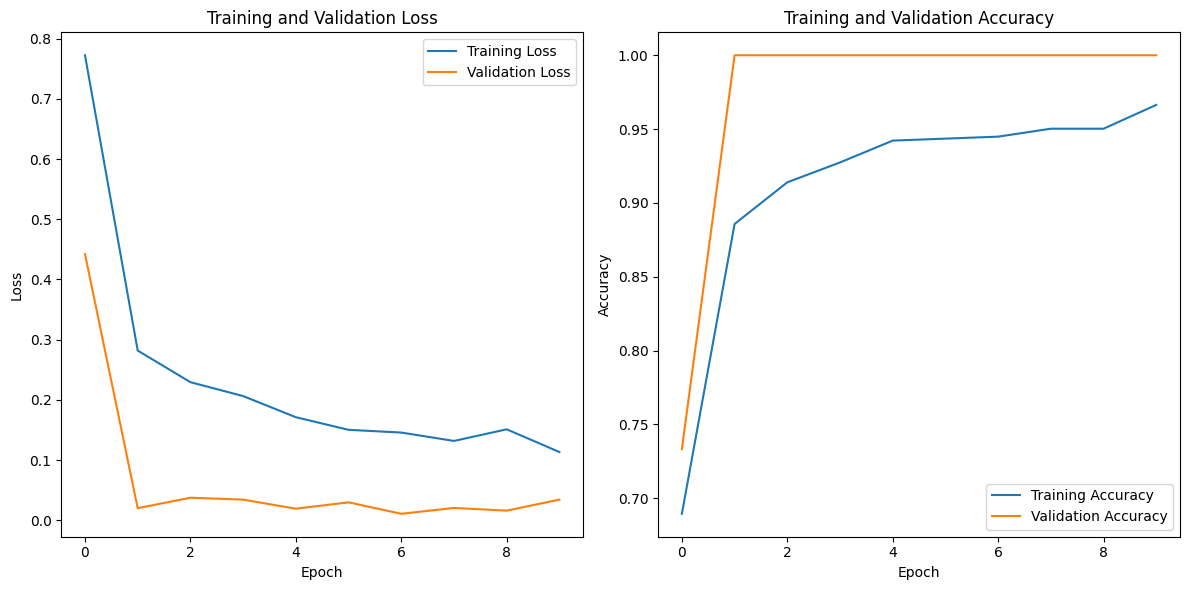

In [83]:

# Defining a custom learning rate schedule function
def learning_rate_schedule(epoch):
    if epoch < 5:
        return 0.0001
    else:
        return 0.00001

# Creating a LearningRateScheduler using the custom learning rate schedule function
lr_scheduler = LearningRateScheduler(learning_rate_schedule)

# Training the model using the defined learning rate scheduler
history = model.fit(
    train_generator,                 
    epochs=10,                   
    validation_data=validation_generator,  
    callbacks=[lr_scheduler]         
)

# Plot training and validation metrics
plt.figure(figsize=(12, 6))

# Plot Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.tight_layout()

plt.show()


In [84]:


# Creating a data generator for the test set using the same data augmentation parameters
test_generator = datagen.flow_from_directory(
    test_path,                    
    target_size=(224, 224),       
    batch_size=32,                
    class_mode='categorical',  
    classes=top_3          
)

Found 15 images belonging to 3 classes.


In [85]:
# Evaluating model on the test data using the test generator
test_results = model.evaluate(test_generator)

# Printting or use these metric values as needed for further analysis or reporting.
print("Test Loss:", test_results[0])
print("Test Accuracy:", test_results[1])


1/1 [==============================] - 2s 2s/step - loss: 0.0088 - accuracy: 1.0000
Test Loss: 0.00876887608319521
Test Accuracy: 1.0


In [86]:
# Generating predicted probabilities for the test data using the model
y_pred_prob = model.predict(test_generator)

# Converting predicted probabilities to class labels (argmax along the second axis)
y_pred = np.argmax(y_pred_prob, axis=1)

# Obtaining true class labels from the test generator
y_true = test_generator.classes


1/1 [==============================] - 2s 2s/step


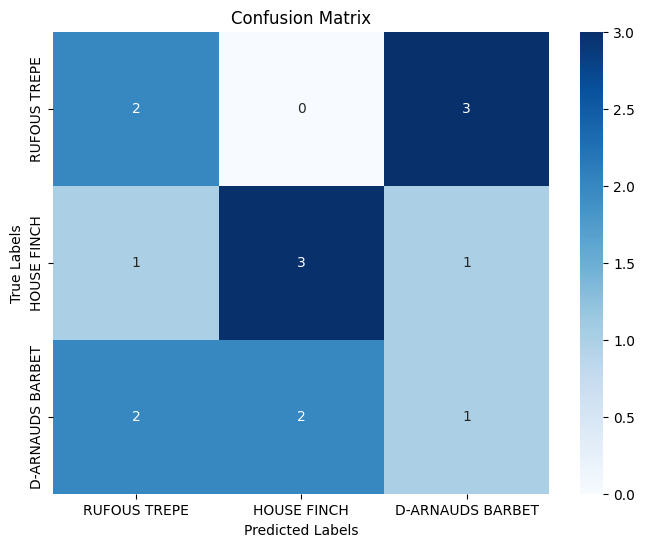

In [87]:
# Calculating the confusion matrix using true and predicted labels
conf_matrix = confusion_matrix(y_true, y_pred)

# Creating a heatmap to visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_matrix,            
    annot=True,               
    fmt="d",                 
    cmap="Blues",              
    xticklabels=top_3,  
    yticklabels=top_3   
)


plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [88]:
# Generating a classification report using true and predicted labels, and specify target names
class_report = classification_report(y_true, y_pred, target_names=top_3)

# Printing the classification report
print("Classification Report:")
print(class_report)


Classification Report:
                  precision    recall  f1-score   support

    RUFOUS TREPE       0.40      0.40      0.40         5
     HOUSE FINCH       0.60      0.60      0.60         5
D-ARNAUDS BARBET       0.20      0.20      0.20         5

        accuracy                           0.40        15
       macro avg       0.40      0.40      0.40        15
    weighted avg       0.40      0.40      0.40        15



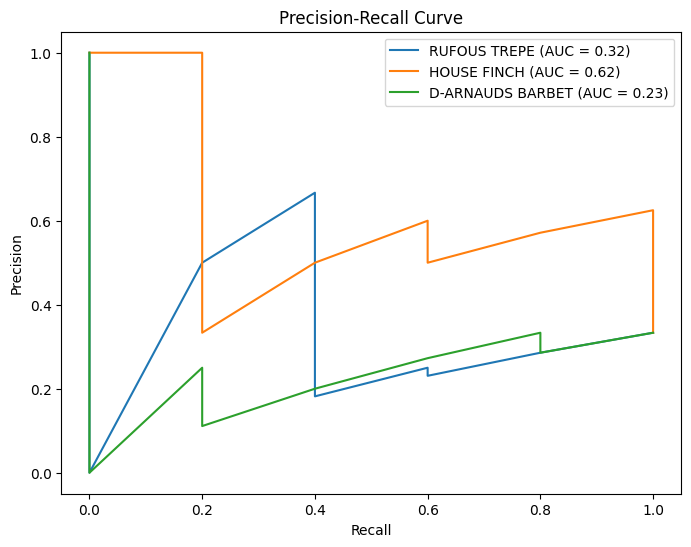

In [89]:
y_true_bin = label_binarize(y_true, classes=[0, 1, 2])

# Initializing dictionaries to store precision, recall, and PR AUC for each class
precision = dict()
recall = dict()
pr_auc = dict()

# Looping through each class
for i in range(len(top_3)):
    precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], y_pred_prob[:, i])
    pr_auc[i] = auc(recall[i], precision[i])
    
# Creating a figure for the Precision-Recall Curve   
plt.figure(figsize=(8, 6))
for i in range(len(top_3)):
    plt.plot(recall[i], precision[i], label=f'{top_3[i]} (AUC = {pr_auc[i]:.2f})')
    
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

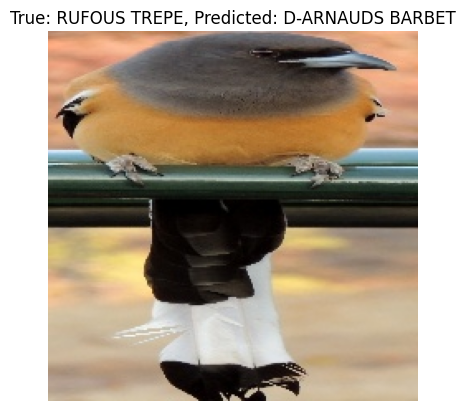

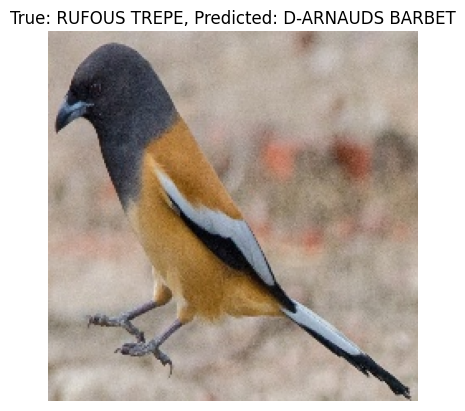

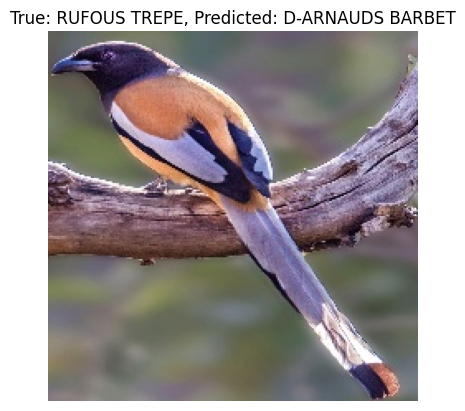

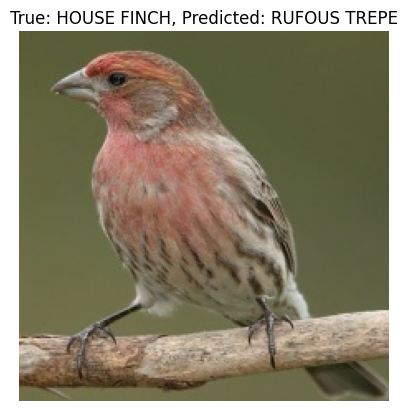

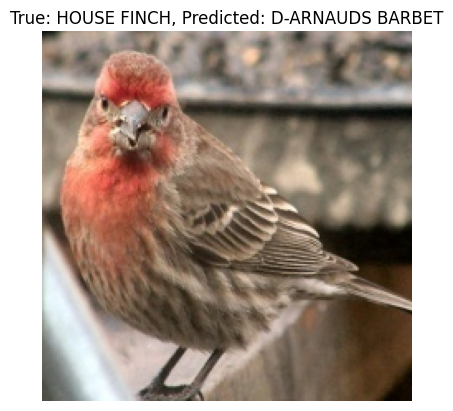

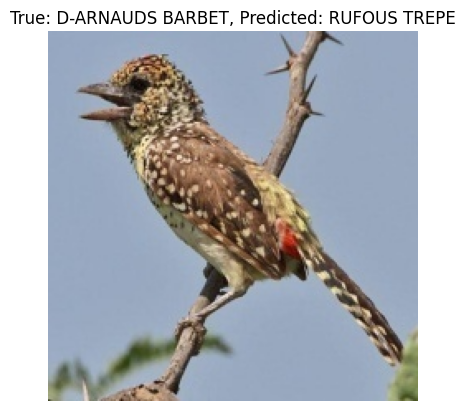

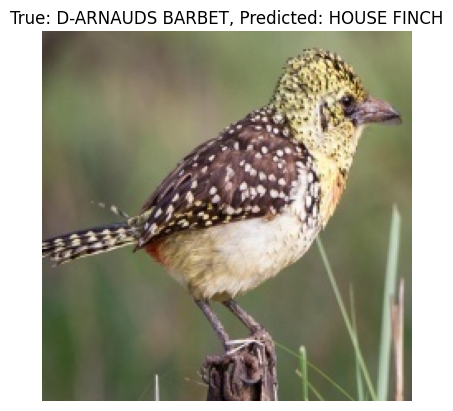

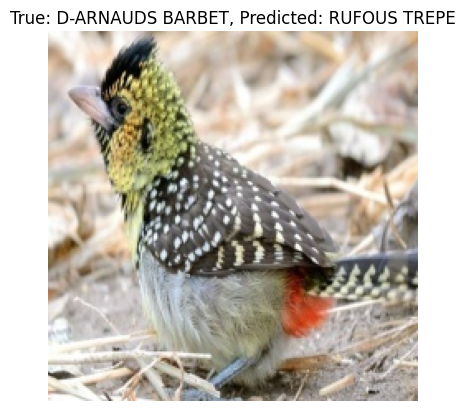

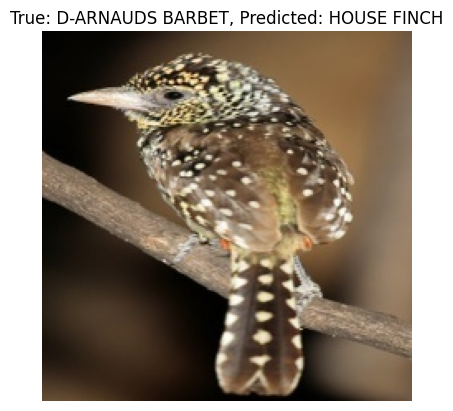

In [90]:
# Finding indices where true labels are not equal to predicted labels
incorrect_indices = np.where(y_true != y_pred)[0]

# Iterating over incorrect indices to visualize misclassified images
for index in incorrect_indices: 
    # Geting image path, true label, and predicted label for the misclassified example
    img_path = test_generator.filepaths[index]
    true_label = top_3[y_true[index]]
    predicted_label = top_3[y_pred[index]]
    
    # Reading the image using plt.imread
    img = plt.imread(img_path)

    # Displaying the misclassified image with true and predicted labels
    plt.imshow(img)
    plt.title(f"True: {true_label}, Predicted: {predicted_label}")
    plt.axis('off')
    plt.show()